In [1]:
%load_ext lab_black

In [2]:
from pathlib import Path

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import re
from IPython.display import display, HTML

# Checking the quality and predictive power of WHO Data on COVID-19

# Business Understanding
The WHO - the public health agency of the UN - has the goal to achiev the attainment of the highest possible level of health for everyone. During a pandemic, this mission becomes particularly important and difficult since the high communicability and the potentially severe course of COVID-19 imposes a large burden on people and their health system independent of any borders.

To mitigate the effects of disease outbreaks, the WHO monitors public health risks and coordinates responses to health emergencies. WHO's actions depends on their collected data. [This dashboard](https://covid19.who.int/) is one of WHOs publically available information on COVID.

## Questions
- How good is the data used by the WHO?
- Are high incidences spatially bound (i.e., stay within a region)?
- Are epidemiological assessments increasing the performance of a machine-learning model additional to raw data? 

## Data Preparation

The data was scraped using `scheduler.py`. Its mechanic is described in `scrape.ipynb`. We read in all scraped data which are a snapshot of [WHO's dashboard on COVID-19 infections](https://covid19.who.int/) and concate them to a dataframe that also functions as a timeseries. Since treating the data as a timeseries is not intended, we need to expect anomalies.

In [3]:
tables = os.listdir("scraped/")
timeseries = pd.concat(
    [
        pd.read_csv("scraped/" + file_).assign(
            date=re.match(r"\D+(\d{4}-\d{2}-\d{2}).+", file_)[1]
        )
        for file_ in tables
    ]
).rename(
    {
        "Cases - cumulative total": "cases_cumulative",
        "Cases - cumulative total per 1 million population": "cases_cumulative_per_million",
        "Deaths - cumulative total": "deaths_cumulative",
        "Deaths - cumulative total per 1 million population": "deaths_cumulative_per_million",
        "Cases - newly reported in last 7 days": "cases_newly_reported_in_7_days",
        "Cases - newly reported in last 24 hours": "cases_newly_reported_in_24_hours",
        "Deaths - newly reported in last 7 days": "deaths_newly_reported_in_7_days",
        "Deaths - newly reported in last 24 hours": "deaths_newly_reported_in_24_hours",
        "Transmission Classification": "transmission_classification",
    },
    axis=1,
)

In [4]:
timeseries.tail()

,WHO_Name,WHO_Region,cases_cumulative,cases_cumulative_per_million,cases_newly_reported_in_7_days,cases_newly_reported_in_24_hours,deaths_cumulative,deaths_cumulative_per_million,deaths_newly_reported_in_7_days,deaths_newly_reported_in_24_hours,transmission_classification,date
233,Saint Helena,Africa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No cases,2021-01-30
234,Tokelau,Western Pacific,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No cases,2021-01-30
235,Tonga,Western Pacific,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No cases,2021-01-30
236,Turkmenistan,Europe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No cases,2021-01-30
237,Tuvalu,Western Pacific,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No cases,2021-01-30


### Question 1: How good is the data used by the WHO?
In the following I will try to answer the consistancy of the data set and the reporting behavior.

#### Missing data
Generally, missing data in this dataset is seldom. There is no variable that has over 1% missing data. But is the data really this good?

In [5]:
round(timeseries.isna().sum() / timeseries.shape[0] * 100, ndigits=2)

WHO_Name                             0.00
WHO_Region                           0.64
cases_cumulative                     0.22
cases_cumulative_per_million         0.64
cases_newly_reported_in_7_days       0.22
cases_newly_reported_in_24_hours     0.22
deaths_cumulative                    0.22
deaths_cumulative_per_million        0.64
deaths_newly_reported_in_7_days      0.22
deaths_newly_reported_in_24_hours    0.22
transmission_classification          0.64
date                                 0.00
dtype: float64

#### Consitancy
Let's check the cumulative counts. Per definition, these numbers cannot decrease. So a value from one day to the other is either larger or equally large. How many entries in this data set satisfy this criterion? But first, let's check if there any negative values that we did not expect.

In [6]:
(timeseries.select_dtypes(include=float) < 0).sum()

cases_cumulative                     0
cases_cumulative_per_million         0
cases_newly_reported_in_7_days       0
cases_newly_reported_in_24_hours     3
deaths_cumulative                    0
deaths_cumulative_per_million        0
deaths_newly_reported_in_7_days      0
deaths_newly_reported_in_24_hours    4
dtype: int64

Apparently, it is possible to downwards correct reports. So we need to expect some decreasing values in our cumulative columns.

In [7]:
def create_diff(timespan, diff_type="diff"):
    return (
        timeseries.sort_values(by=["WHO_Name", "date"])
        .set_index(["WHO_Region", "WHO_Name", "date"])
        .groupby("WHO_Name")[["cases_cumulative", "deaths_cumulative"]]
        .pipe(lambda x: getattr(x, diff_type)(timespan))
        .rename(lambda x: f"{x}_diff_{timespan}", axis=1)
    )


def diffs_over_time(diff_type="diff"):
    return (
        pd.concat(
            [create_diff(i, diff_type) for i in range(0, 30)],
            axis=1,
            verify_integrity=True,
        )
        .reset_index()
        .melt(id_vars=["WHO_Region", "WHO_Name", "date"])
        .assign(
            count_type=lambda x: x.variable.apply(
                lambda y: "cases" if "cases" in y else "deaths"
            ),
            day_diff=lambda x: x.variable.apply(
                lambda y: re.search(r"\d+", y)[0]
            ).astype(int),
        )
    )

In [8]:
diff_one = create_diff(1)

print(
    round(
        len(diff_one[diff_one["cases_cumulative_diff_1"] < 0]) / len(diff_one) * 100,
        ndigits=2,
    ),
    "% of the cumulative cases decrease from one day to the other",
)

print(
    round(
        len(diff_one[diff_one["deaths_cumulative_diff_1"] < 0]) / len(diff_one) * 100,
        ndigits=2,
    ),
    "% of the cumulative deaths decrease from one day to the other",
)

0.09 % of the cumulative cases decrease from one day to the other
0.06 % of the cumulative deaths decrease from one day to the other


Let's check if there is any pattern among the different WHO_Regions.

In [9]:
diff_one.query("cases_cumulative_diff_1 < 0").groupby("WHO_Region").size()

WHO_Region
Africa             4
Americas           2
Europe             5
Western Pacific    2
dtype: int64

In [10]:
diff_one.query("deaths_cumulative_diff_1 < 0").groupby("WHO_Region").size()

WHO_Region
Africa      4
Americas    1
Europe      4
dtype: int64

There is nothing supsicious about the decrease of cumulative reports among the regions.

How about their information on `Cases/Deaths - newly reported in last 7 days`. This should be the same as if taking the difference between the cumulative death and case counts from 7 days ago.

In [11]:
diff_seven = create_diff(7)

diffs_expected = timeseries.set_index(["WHO_Name", "date"]).loc[
    :,
    [
        "cases_newly_reported_in_7_days",
        "deaths_newly_reported_in_7_days",
    ],
]

diffs_and_expected_diffs = diff_seven.merge(
    diffs_expected, left_index=True, right_index=True, validate="1:1"
).dropna()

In [12]:
print(
    round(
        (
            diffs_and_expected_diffs["cases_cumulative_diff_7"]
            != diffs_and_expected_diffs["cases_newly_reported_in_7_days"]
        ).sum()
        / len(diffs_and_expected_diffs)
        * 100,
        ndigits=2,
    ),
    "% of the difference taken from the cumulative case count from 7 days ago don't match up with the column of newly reported deaths",
)

print(
    round(
        (
            diffs_and_expected_diffs["deaths_cumulative_diff_7"]
            != diffs_and_expected_diffs["deaths_newly_reported_in_7_days"]
        ).sum()
        / len(diffs_and_expected_diffs)
        * 100,
        ndigits=2,
    ),
    "% of the difference taken from the cumulative deaths count from 7 days ago don't match up with the column of newly reported deaths",
)

16.81 % of the difference taken from the cumulative case count from 7 days ago don't match up with the column of newly reported deaths
11.77 % of the difference taken from the cumulative deaths count from 7 days ago don't match up with the column of newly reported deaths


In [13]:
print(
    "Relative amount of missmatches of reported and calculated cases in the last 7 days compared to reports made world wide."
)
round(
    diffs_and_expected_diffs.query(
        "cases_cumulative_diff_7 != cases_newly_reported_in_7_days"
    )
    .groupby("WHO_Region")
    .size()
    / len(diffs_and_expected_diffs)
    * 100,
    ndigits=2,
)

Relative amount of missmatches of reported and calculated cases in the last 7 days compared to reports made world wide.


WHO_Region
Africa                   3.12
Americas                 2.39
Eastern Mediterranean    1.40
Europe                   7.83
South-East Asia          0.45
Western Pacific          1.20
dtype: float64

In [14]:
print(
    "Relative amount of missmatch of reported and calculated cases in the last 7 days compared to reports within this region."
)
round(
    diffs_and_expected_diffs.query(
        "cases_cumulative_diff_7 != cases_newly_reported_in_7_days"
    )
    .groupby("WHO_Region")
    .size()
    / diffs_and_expected_diffs.groupby("WHO_Region").size()
    * 100,
    ndigits=2,
)

Relative amount of missmatch of reported and calculated cases in the last 7 days compared to reports within this region.


WHO_Region
Africa                   14.80
Americas                 10.28
Eastern Mediterranean    15.04
Europe                   29.94
Other                      NaN
South-East Asia           9.75
Western Pacific           8.16
dtype: float64

In [15]:
print(
    "Relative amount of missmatch of reported and calculated deaths in the last 7 days compared to reports world wide."
)
round(
    diffs_and_expected_diffs.query(
        "deaths_cumulative_diff_7 != deaths_newly_reported_in_7_days"
    )
    .groupby("WHO_Region")
    .size()
    / len(diffs_and_expected_diffs)
    * 100,
    ndigits=2,
)

Relative amount of missmatch of reported and calculated deaths in the last 7 days compared to reports world wide.


WHO_Region
Africa                   1.66
Americas                 1.53
Eastern Mediterranean    1.19
Europe                   6.32
South-East Asia          0.31
Western Pacific          0.34
dtype: float64

In [16]:
print(
    "Relative amount of missmatch of reported and calculated deaths in the last 7 days compared to reports within this region."
)
round(
    diffs_and_expected_diffs.query(
        "deaths_cumulative_diff_7 != deaths_newly_reported_in_7_days"
    )
    .groupby("WHO_Region")
    .size()
    / diffs_and_expected_diffs.groupby("WHO_Region").size()
    * 100,
    ndigits=2,
)

Relative amount of missmatch of reported and calculated deaths in the last 7 days compared to reports within this region.


WHO_Region
Africa                    7.85
Americas                  6.55
Eastern Mediterranean    12.81
Europe                   24.19
Other                      NaN
South-East Asia           6.78
Western Pacific           2.29
dtype: float64

The percentages don't add up when comparing at country and region level. This is due to one entry called "Global" that falls out of the Region analysis.

In [17]:
diffs_and_expected_diffs.query(
    "WHO_Name.notna() and WHO_Region.isna()"
).reset_index().WHO_Name.unique()[0]

'Global'

This analyses made strict comparisons between the difference of cumulative values and the column of newly reported cases/deaths. How is this difference behaving relativly?

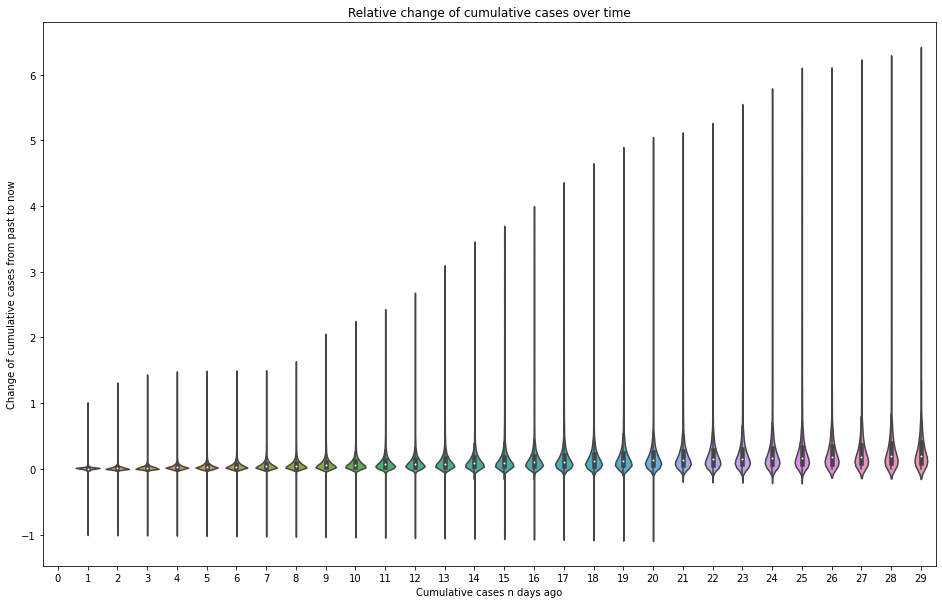

In [18]:
changes_over_time = diffs_over_time(diff_type="pct_change")
changes_over_time = changes_over_time[np.isfinite(changes_over_time.value)]

plt.figure(figsize=(16, 10))
sns.violinplot(
    x="day_diff",
    y="value",
    data=changes_over_time.query(
        "count_type=='cases'",
    ),
    scale="count",
).set(
    title="Relative change of cumulative cases over time",
    xlabel="Cumulative cases n days ago",
    ylabel="Change of cumulative cases from past to now",
)
plt.show()

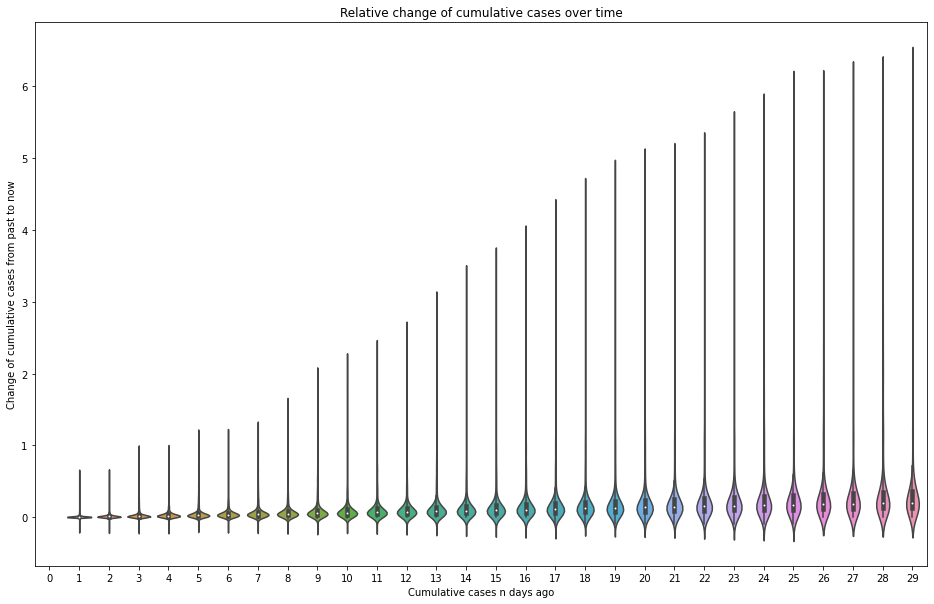

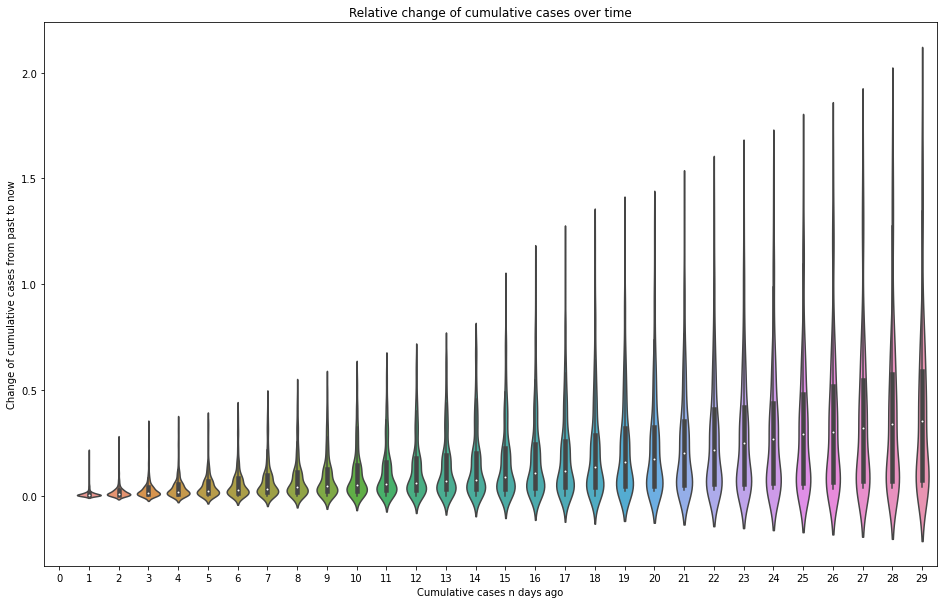

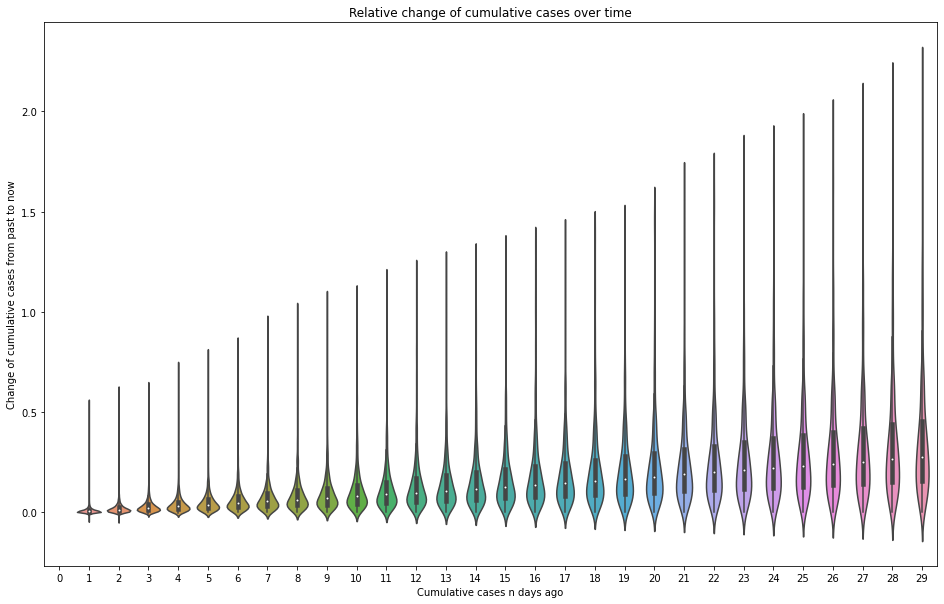

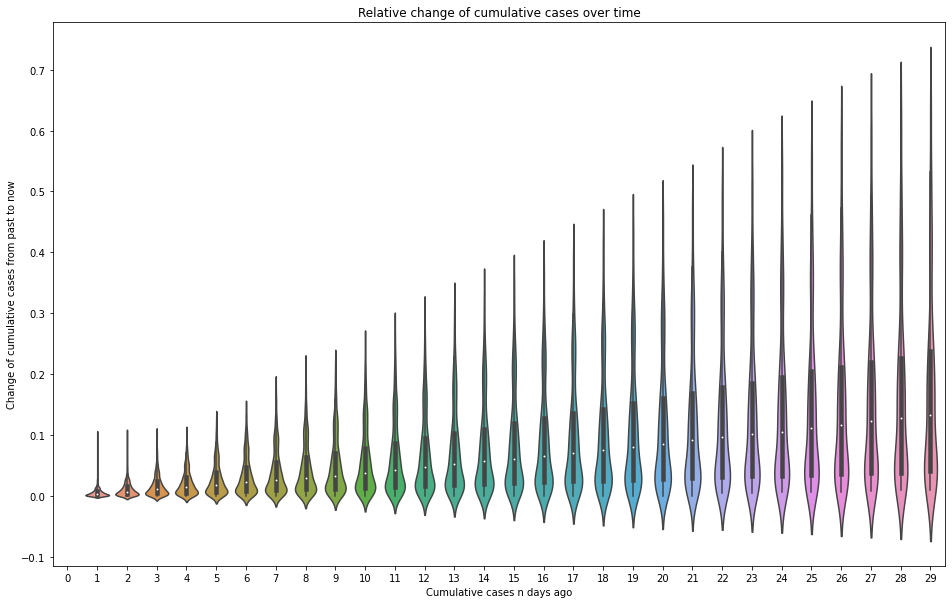

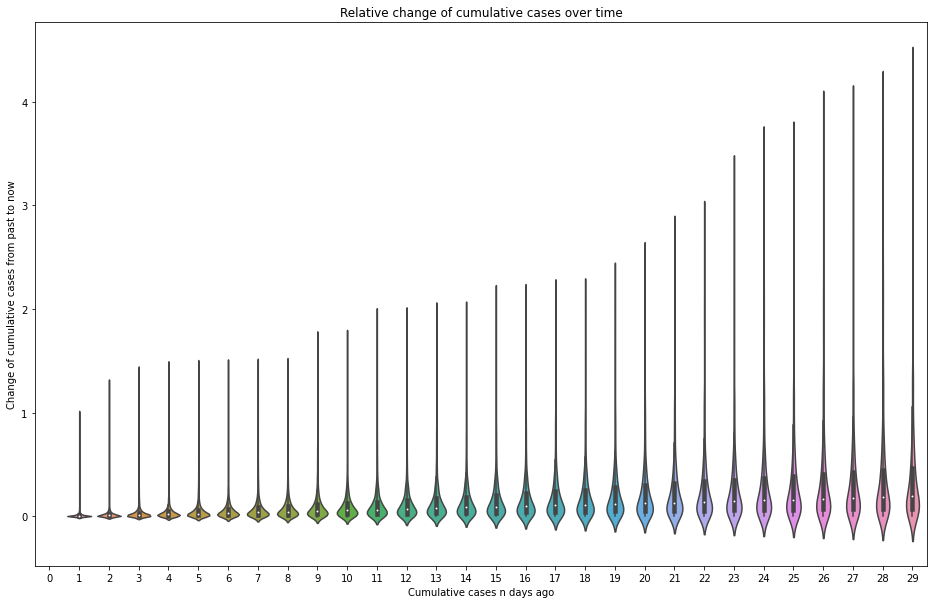

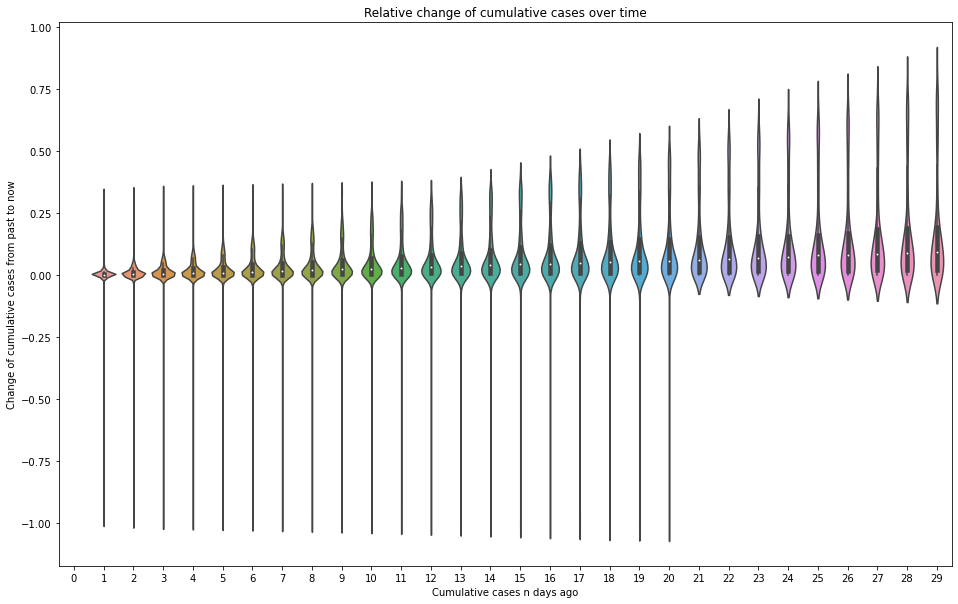

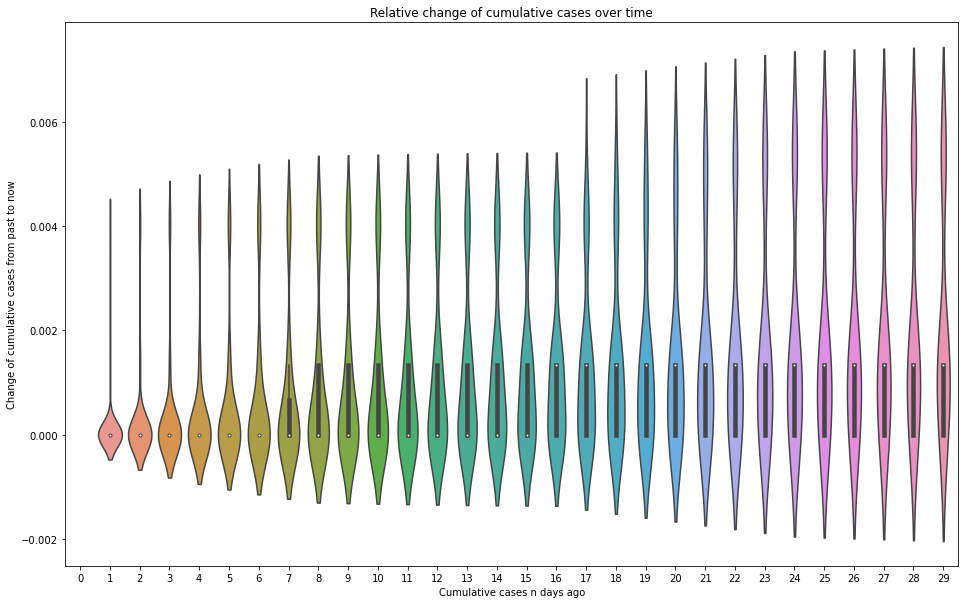

In [19]:
for region in timeseries.WHO_Region.unique():
    if isinstance(region, str):
        display(HTML(f"<b>{region}</b>"))
        plt.figure(figsize=(16, 10))
        sns.violinplot(
            x="day_diff",
            y="value",
            data=changes_over_time.query(
                f"count_type=='cases' and WHO_Region=='{region}'",
            ),
            scale="count",
        ).set(
            title="Relative change of cumulative cases over time",
            xlabel="Cumulative cases n days ago",
            ylabel="Change of cumulative cases from past to now",
        )
        plt.show()

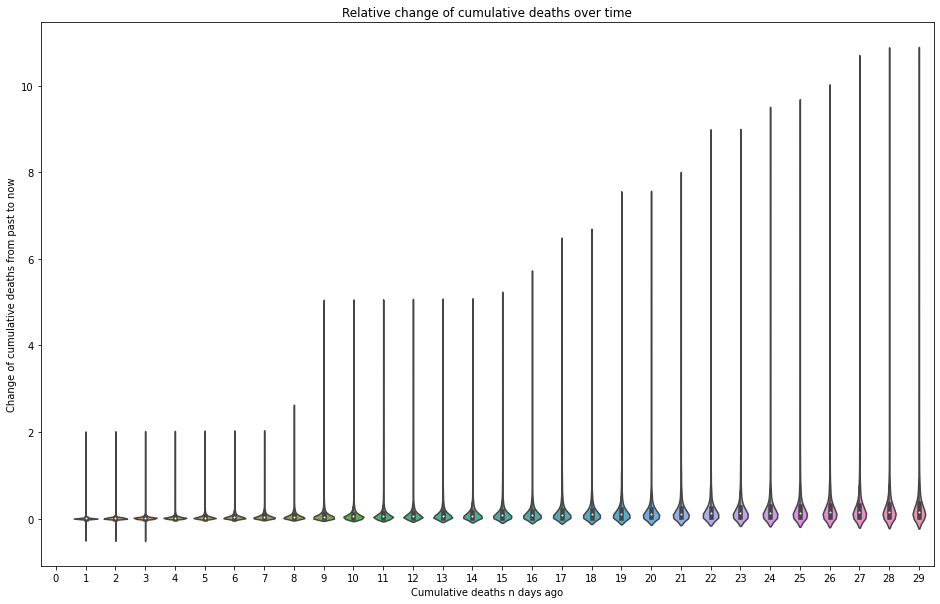

In [20]:
plt.figure(figsize=(16, 10))
sns.violinplot(
    x="day_diff",
    y="value",
    data=changes_over_time.query(
        "count_type=='deaths'",
    ),
    scale="count",
).set(
    title="Relative change of cumulative deaths over time",
    xlabel="Cumulative deaths n days ago",
    ylabel="Change of cumulative deaths from past to now",
)
plt.show()

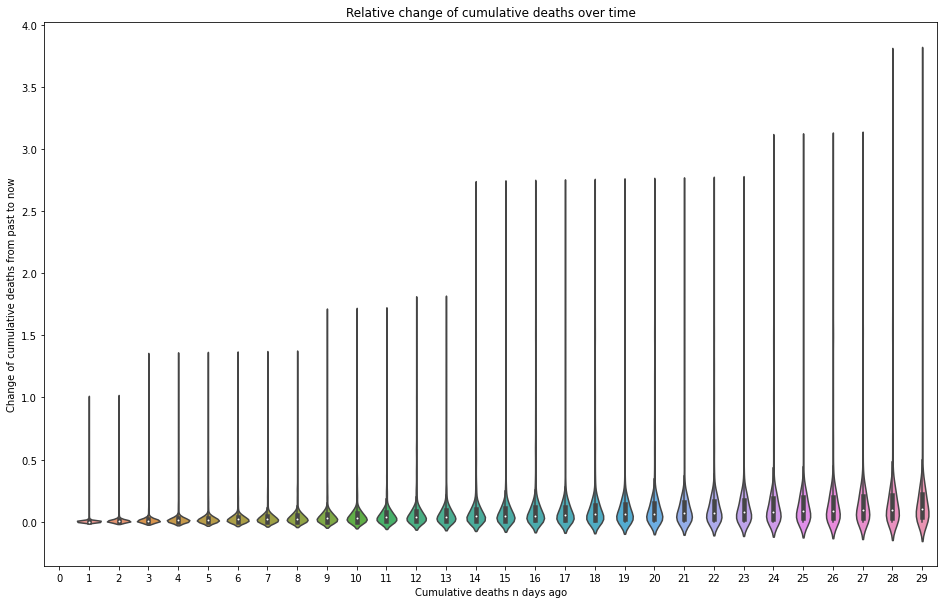

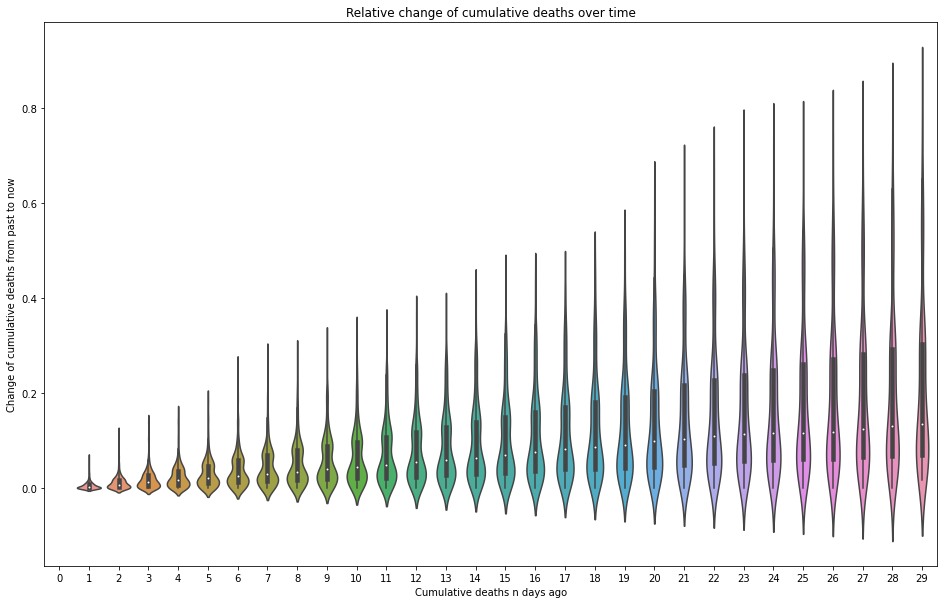

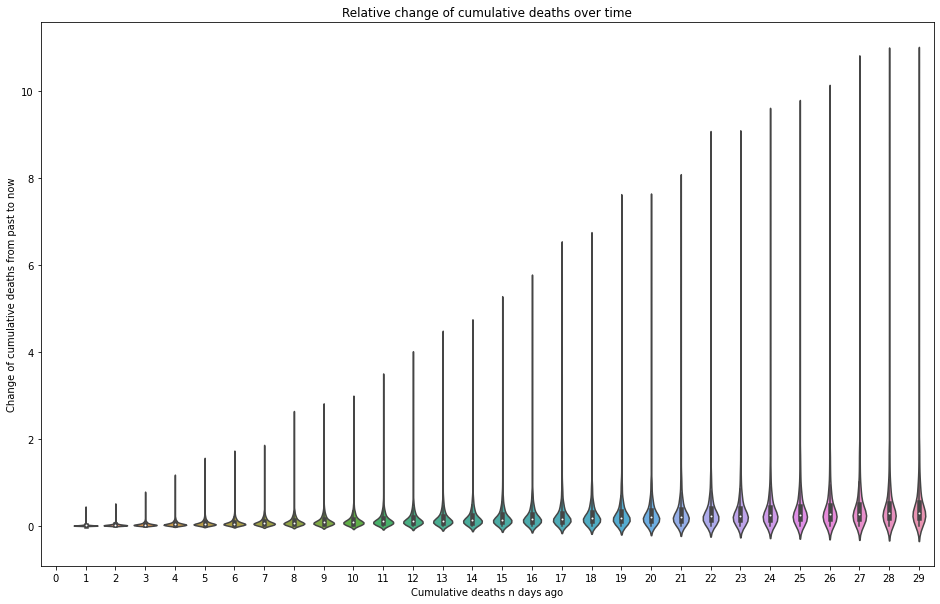

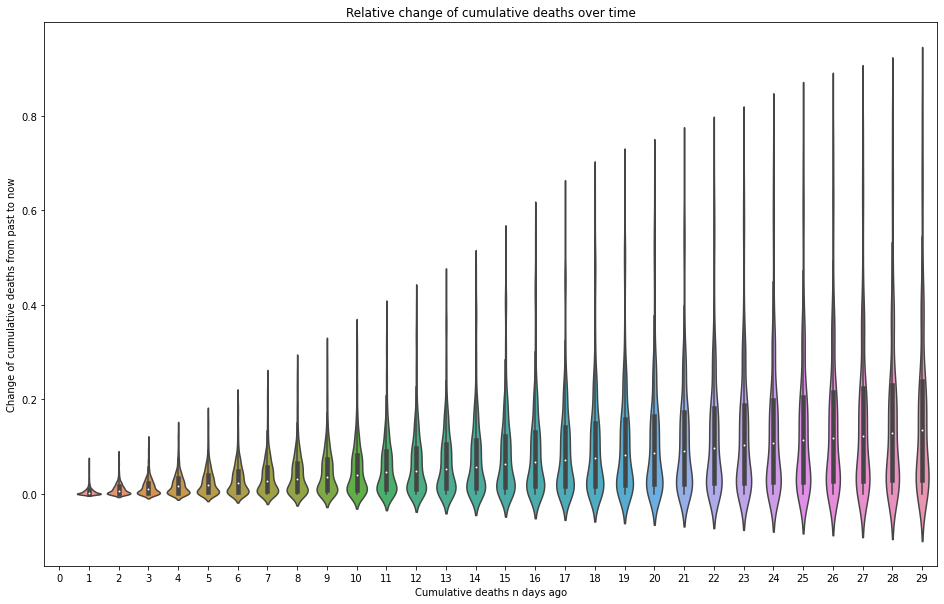

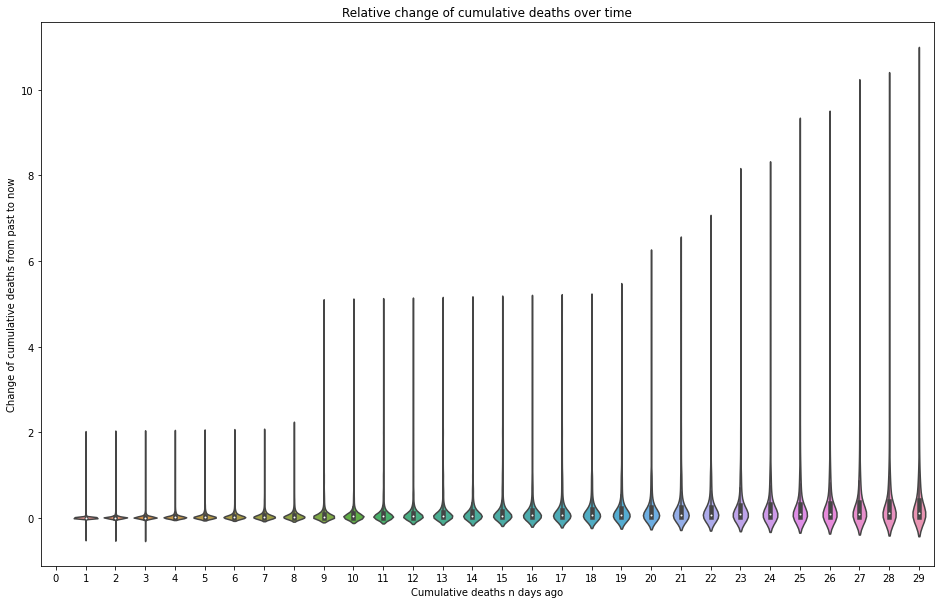

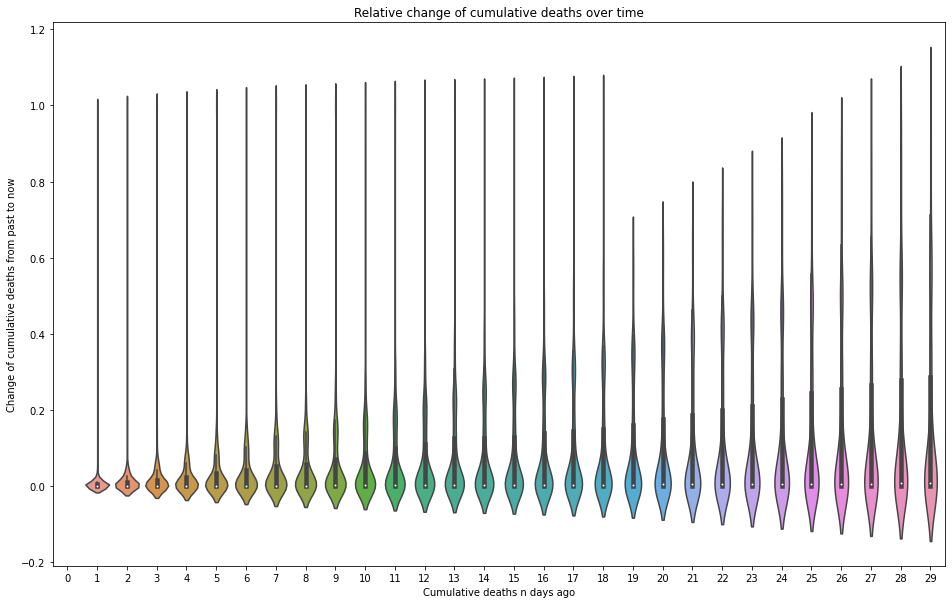

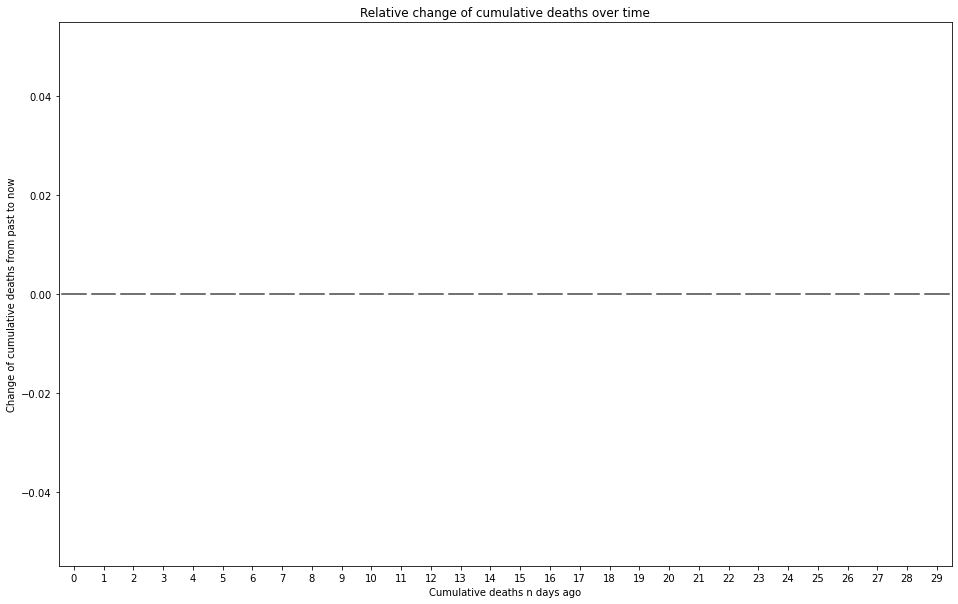

In [21]:
for region in timeseries.WHO_Region.unique():
    if isinstance(region, str):
        display(HTML(f"<b>{region}</b>"))
        plt.figure(figsize=(16, 10))
        sns.violinplot(
            x="day_diff",
            y="value",
            data=changes_over_time.query(
                f"count_type=='deaths' and WHO_Region=='{region}'",
            ),
            scale="count",
        ).set(
            title="Relative change of cumulative deaths over time",
            xlabel="Cumulative deaths n days ago",
            ylabel="Change of cumulative deaths from past to now",
        )
    plt.show()

We can see that the increase of the cumulative values in part increases linearly, in parts exponetially. The spread usually increases over time, with the most values being aroung 0. Most values are increasing positevly, with very few one decreasing.

#### Reporting behavior
Within which time span are countries reporting new cases?

In [22]:
diffs_over_time_df = diffs_over_time()

In [23]:
diffs_over_time_df.head()

,WHO_Region,WHO_Name,date,variable,value,count_type,day_diff
0,Eastern Mediterranean,Afghanistan,2020-11-29,cases_cumulative_diff_0,0.0,cases,0
1,Eastern Mediterranean,Afghanistan,2020-11-30,cases_cumulative_diff_0,0.0,cases,0
2,Eastern Mediterranean,Afghanistan,2020-12-01,cases_cumulative_diff_0,0.0,cases,0
3,Eastern Mediterranean,Afghanistan,2020-12-02,cases_cumulative_diff_0,0.0,cases,0
4,Eastern Mediterranean,Afghanistan,2020-12-03,cases_cumulative_diff_0,0.0,cases,0


In [24]:
diffs_over_time_relative = diffs_over_time_df.groupby(["count_type", "day_diff"]).agg(
    {"value": lambda x: sum(x != 0)}
) / len(timeseries)

In [25]:
alt.Chart(
    diffs_over_time_relative.reset_index(),
    title="Proportion of countries with increaseing cumulative cases/deaths over time",
).mark_bar(size=7).encode(
    x=alt.X(
        "day_diff", title="Days until next report", scale=alt.Scale(domain=(1, 29))
    ),
    y=alt.Y(
        "value", axis=alt.Axis(format="%"), title="Proportion that made a new report"
    ),
    color=alt.Color("count_type", title="Reporting type"),
)

alt.Chart(...)

In [26]:
diffs_over_time_relative_per_region = diffs_over_time_df.groupby(
    ["WHO_Region", "count_type", "day_diff"]
).agg({"value": lambda x: sum(x != 0)}) / diffs_over_time_df.groupby(
    ["WHO_Region", "count_type", "day_diff"]
).size().to_frame(
    "value"
)

In [27]:
alt.Chart(
    diffs_over_time_relative_per_region.reset_index(),
    title="Proportion of countries with increaseing cumulative cases/deaths over time",
).mark_bar(size=7).encode(
    x=alt.X(
        "day_diff", title="Days until next report", scale=alt.Scale(domain=(1, 29))
    ),
    y=alt.Y(
        "value", axis=alt.Axis(format="%"), title="Proportion that made a new report"
    ),
    color=alt.Color("count_type", title="Reporting type"),
    facet=alt.Facet("WHO_Region", columns=2),
).resolve_scale(
    x="independent"
)

alt.Chart(...)

Let's check when we are most likely to encouter days without new reports.

In [28]:
def highlight_min(s):
    is_max = s == s.min()
    return ["background-color: green" if v else "" for v in is_max]


def highlight_max(s):
    is_max = s == s.max()
    return ["background-color: red" if v else "" for v in is_max]

In [29]:
def show_week_day_statistic(timeseries):
    week_day_statistic = (
        timeseries.assign(
            day_name=lambda x: x.date.apply(lambda y: pd.to_datetime(y).day_name())
        )
        .sort_values(by=["WHO_Name", "date"])
        .set_index(["WHO_Name", "date", "day_name"])
        .groupby(["WHO_Name", "day_name"])[["cases_cumulative", "deaths_cumulative"]]
        .diff(1)
        .groupby("day_name")
        .agg(lambda x: sum(x != 0))
    )
    return (
        (week_day_statistic / week_day_statistic.sum() * 100)
        .style.apply(highlight_max)
        .apply(highlight_min)
    )

In [30]:
week_day_statistic = (
    timeseries.assign(
        day_name=lambda x: x.date.apply(lambda y: pd.to_datetime(y).day_name())
    )
    .sort_values(by=["WHO_Name", "date"])
    .set_index(["WHO_Name", "date", "day_name"])
    .groupby(["WHO_Name", "day_name"])[["cases_cumulative", "deaths_cumulative"]]
    .diff(1)
    .groupby("day_name")
    .agg(lambda x: sum(x != 0))
)

In [31]:
show_week_day_statistic(timeseries)

,cases_cumulative,deaths_cumulative
day_name,,
Friday,14.538491,14.489615
Monday,12.937572,13.131214
Saturday,14.523171,14.509302
Sunday,14.446572,14.460085
Thursday,14.538491,14.479772
Tuesday,14.546151,14.499459
Wednesday,14.469552,14.430554


We can see that least days without new reported cases and deaths (12.94% and 13.13% respectively) are reported on a Monday. The value is the highest on Tuesday for case and Saturday for death reports. This could explain why the strong manjority does not reports new numbers every day besides not having anything to report: There might be a reporting gap during the weekend.

In [32]:
for region in timeseries.WHO_Region.unique():
    if isinstance(region, str):
        display(HTML(f"<b>{region}</b>"))
        display(show_week_day_statistic(timeseries.query("WHO_Region==@region")))
        print("\n\n")

,cases_cumulative,deaths_cumulative
day_name,,
Friday,14.650873,14.616432
Monday,12.874065,13.163867
Saturday,14.463840,14.525647
Sunday,14.401496,14.480254
Thursday,14.557357,14.571039
Tuesday,14.557357,14.298684
Wednesday,14.495012,14.344076


,cases_cumulative,deaths_cumulative
day_name,,
Friday,14.471545,14.587738
Monday,13.008130,13.107822
Saturday,14.471545,14.587738
Sunday,14.471545,14.376321
Thursday,14.471545,14.376321
Tuesday,14.471545,14.587738
Wednesday,14.634146,14.376321


,cases_cumulative,deaths_cumulative
day_name,,
Friday,14.525745,14.447761
Monday,12.926829,13.014925
Saturday,14.525745,14.477612
Sunday,14.525745,14.537313
Thursday,14.525745,14.477612
Tuesday,14.498645,14.597015
Wednesday,14.471545,14.447761


,cases_cumulative,deaths_cumulative
day_name,,
Friday,14.466816,14.425428
Monday,12.975391,13.121434
Saturday,14.541387,14.506927
Sunday,14.615958,14.506927
Thursday,14.466816,14.425428
Tuesday,14.541387,14.588427
Wednesday,14.392245,14.425428


,cases_cumulative,deaths_cumulative
day_name,,
Friday,14.608696,14.479215
Monday,12.800000,13.171415
Saturday,14.539130,14.525922
Sunday,14.330435,14.245680
Thursday,14.608696,14.479215
Tuesday,14.573913,14.525922
Wednesday,14.539130,14.572630


,cases_cumulative,deaths_cumulative
day_name,,
Friday,14.203138,14.307229
Monday,13.377374,13.554217
Saturday,14.616020,14.457831
Sunday,14.368291,14.608434
Thursday,14.450867,14.307229
Tuesday,14.698596,14.457831
Wednesday,14.285714,14.307229


,cases_cumulative,deaths_cumulative
day_name,,
Friday,14.285714,14.285714
Monday,14.285714,14.285714
Saturday,14.285714,14.285714
Sunday,14.285714,14.285714
Thursday,14.285714,14.285714
Tuesday,14.285714,14.285714
Wednesday,14.285714,14.285714
